In [33]:
import os
import glob
import pandas as pd
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
import random
import numpy as np
import cv2
from operator import itemgetter
from skimage import metrics
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
from skimage import data,exposure
import seaborn as sns
from skimage.color import rgb2gray
sns.set(style = "dark", 
        color_codes = True,
        font_scale = 1.5)
random.seed(28)

## Exploratory Data Analysis
### [UTKFace](https://susanqq.github.io/UTKFace/)
- Consists of 20k+ face images in the wild (only single face in one image)
- Provides the correspondingly aligned and cropped faces
- Provides the corresponding landmarks (68 points)
- Images are labelled by age, gender, and ethnicity
- Data will be augumented, by randomly flipping, rotating, changing brightness, saturation etc. 5 different images will be generated from each base image
- Data will be split into 0.7 of training set, and 0.3 of test set

#### Constants

In [2]:
# Provide the path to the downloaded UTKFace dataset
UTKFACE_DIR = "C:/Users/prusak.patryk/Documents/studia/ItML/Project/UTKFace"
RECOGNITION_TRAIN_DIR = './FaceRecognition/AugData/train/images'
RECOGNITION_TEST_DIR = './FaceRecognition/AugData/test/images'
RECOGNITION_VAL_DIR = './FaceRecognition/AugData/val/images'

#### Data Loading

In [3]:
def parse_filepath(filepath):
    try:
        path, filename = os.path.split(filepath)
        filename, ext = os.path.splitext(filename)
        age, _, _, _ = filename.split("_")
        fileSize = os.path.getsize (filepath)
        im = Image.open(filepath)
        width, height = im.size
        return int(age), int(fileSize)/1024, int(width), int(height)
    except Exception as e:
        print("Couldn't parse the file: " + filename)
        return None

In [4]:
files = glob.glob(os.path.join(UTKFACE_DIR, "*.jpg"))

In [5]:
attributes = list(map(parse_filepath, files))

Couldn't parse the file: 39_1_20170116174525125.jpg.chip
Couldn't parse the file: 61_1_20170109142408075.jpg.chip
Couldn't parse the file: 61_1_20170109150557335.jpg.chip


In [6]:
df = pd.DataFrame(attributes)
df['file'] = files
df.columns = ['age', 'file size (KB)','width','height','file']
df = df.dropna()

#### Statistics

In [29]:
MAXAGE = df['age'].max()
df.describe()

,age,file size (KB),width,height
count,23705.000000,23705.000000,23705.0,23705.0
mean,33.300907,4.942352,200.0,200.0
std,19.885708,0.806115,0.0,0.0
min,1.000000,2.011719,200.0,200.0
25%,23.000000,4.402344,200.0,200.0
50%,29.000000,4.855469,200.0,200.0
75%,45.000000,5.366211,200.0,200.0
max,116.000000,11.743164,200.0,200.0


<Axes: title={'center': 'UTKFace'}, xlabel='Age', ylabel='Amount of images'>

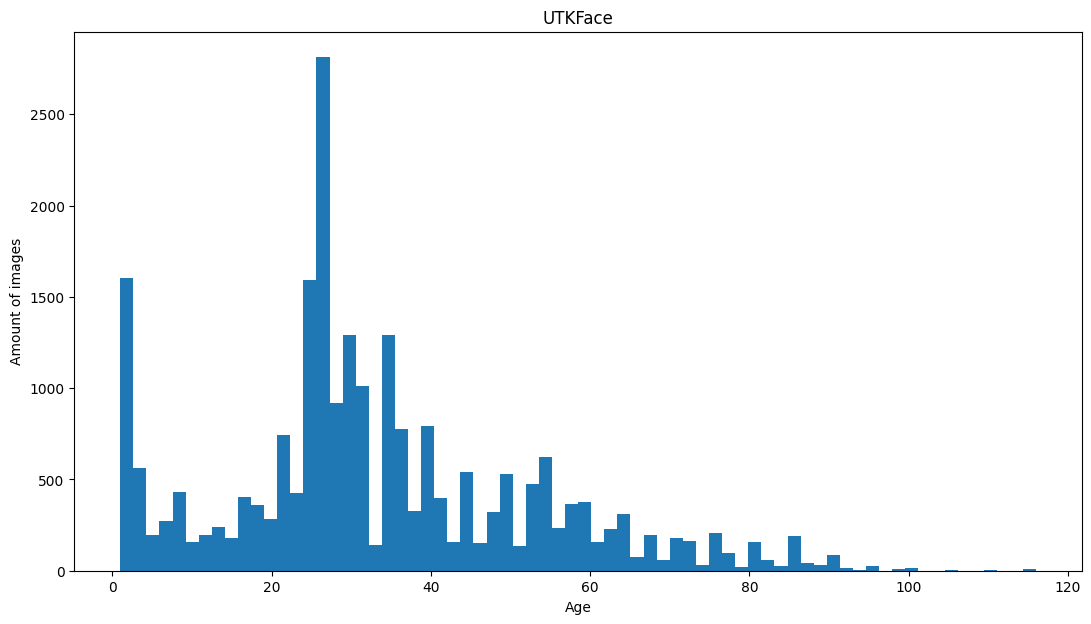

In [67]:
fig = plt.figure(figsize = (13,7))
ax = fig.gca()
df['age'].plot(kind='hist', title='UTKFace', xlabel='Age', ylabel='Amount of images', bins=70)

<Axes: title={'center': 'UTKFace'}, xlabel='file size (KB)', ylabel='Amount of images'>

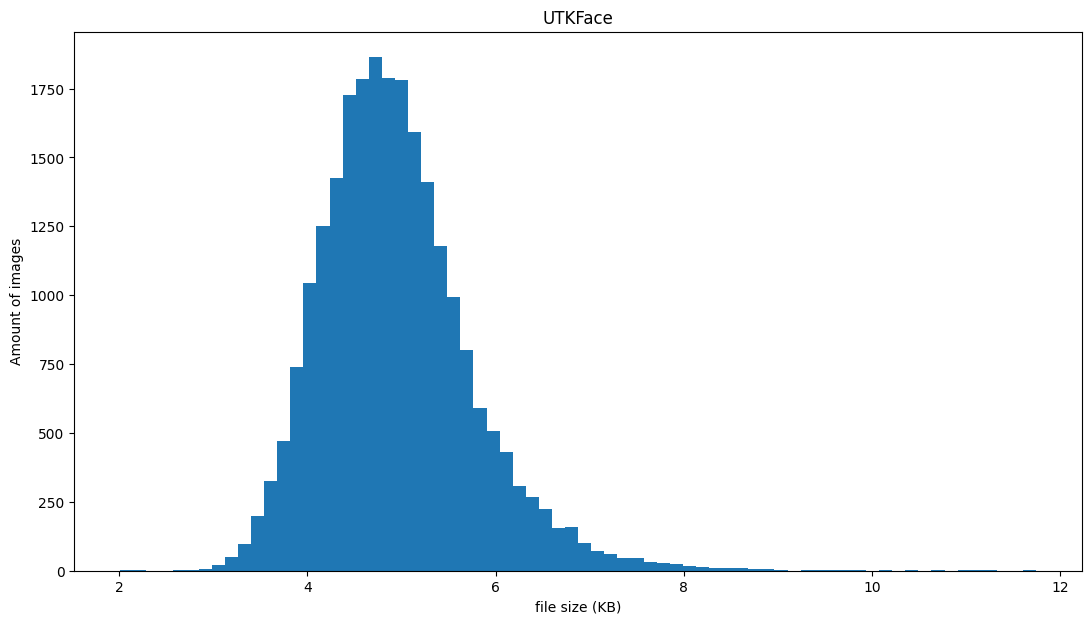

In [68]:
fig = plt.figure(figsize = (13,7))
ax = fig.gca()
df['file size (KB)'].plot(kind='hist', title='UTKFace', xlabel='file size (KB)', ylabel='Amount of images', bins=70)

#### Mean Color Dsitribution

In [70]:
color_distributions = []
for img_path in files:
    try:
        img = cv2.imread(img_path)
        color_distribution = np.bincount(img.flatten(), minlength=256)
        color_distributions.append(color_distribution)
    except Exception as e:
        print("Couldn't parse the file: " + filename)

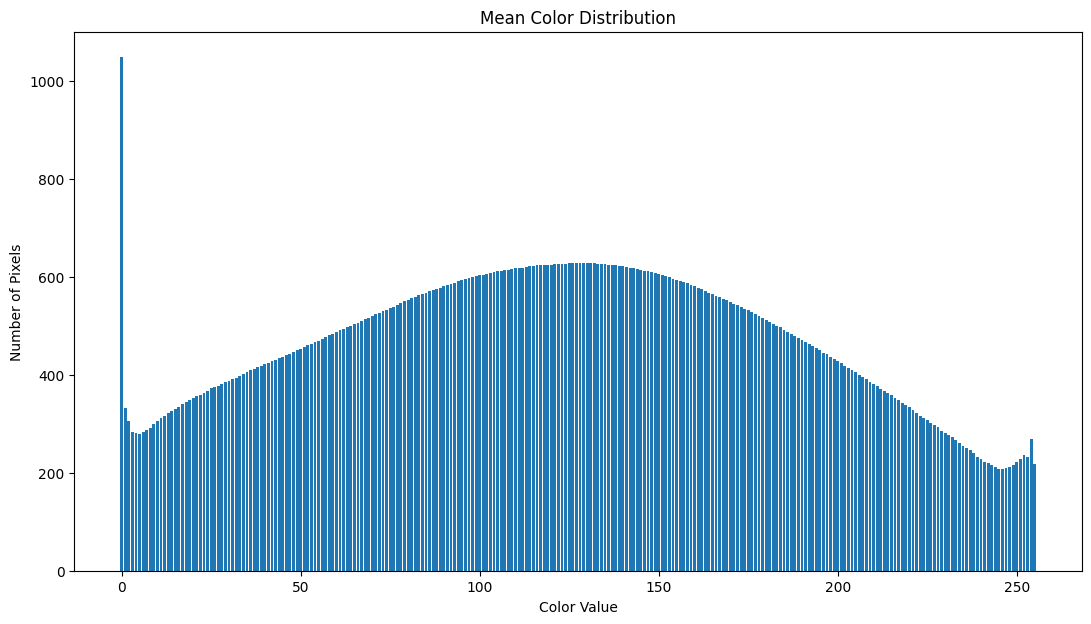

In [73]:
color_distributions = np.array(color_distributions)
color_distributions


mean_color_distribution = np.mean(color_distributions, axis=0)
plt.figure(figsize = (13,7))
plt.bar(np.arange(256), mean_color_distribution)
plt.title("Mean Color Distribution")
plt.xlabel("Color Value")
plt.ylabel("Number of Pixels")
plt.show()

#### RGB Intensities

In [107]:
# For each image get average red, green and blue channel
rgbMeans = []
for img_path in files:
    try:
        img = cv2.imread(img_path)
        
        avgR = np.mean(img[:,:,2])
        avgG = np.mean(img[:,:,1])
        avgB = np.mean(img[:,:,0])
        path, filename = os.path.split(img_path)
        filename, ext = os.path.splitext(filename)
        age, _, _, _ = filename.split("_")
    
        rgbMeans.append([int(age), avgR, avgG, avgB])
    except Exception as e:
        print("Couldn't parse the file: " + filename)

# Group it by age

groups = {}
for l in rgbMeans:
    groups.setdefault(l[0], []).append(l)

rgbMeansGrouped = list(groups.values())

# Sort it

rgbMeansGrouped = sorted(rgbMeansGrouped, key=itemgetter(0))

# Calculate average for each group

meanGroupedR = []
meanGroupedG = []
meanGroupedB = []
xAxes = []

for ageGroup in rgbMeansGrouped:
    sumR = 0
    sumG = 0
    sumB = 0
    for imageData in ageGroup:
        sumR = sumR + imageData[1]
        sumG = sumG + imageData[2]
        sumB = sumB + imageData[3]
    meanGroupedR.append(sumR/len(ageGroup))
    meanGroupedG.append(sumG/len(ageGroup))
    meanGroupedB.append(sumB/len(ageGroup))
    xAxes.append(ageGroup[0][0])

Couldn't parse the file: 39_1_20170116174525125.jpg.chip
Couldn't parse the file: 61_1_20170109142408075.jpg.chip
Couldn't parse the file: 61_1_20170109150557335.jpg.chip


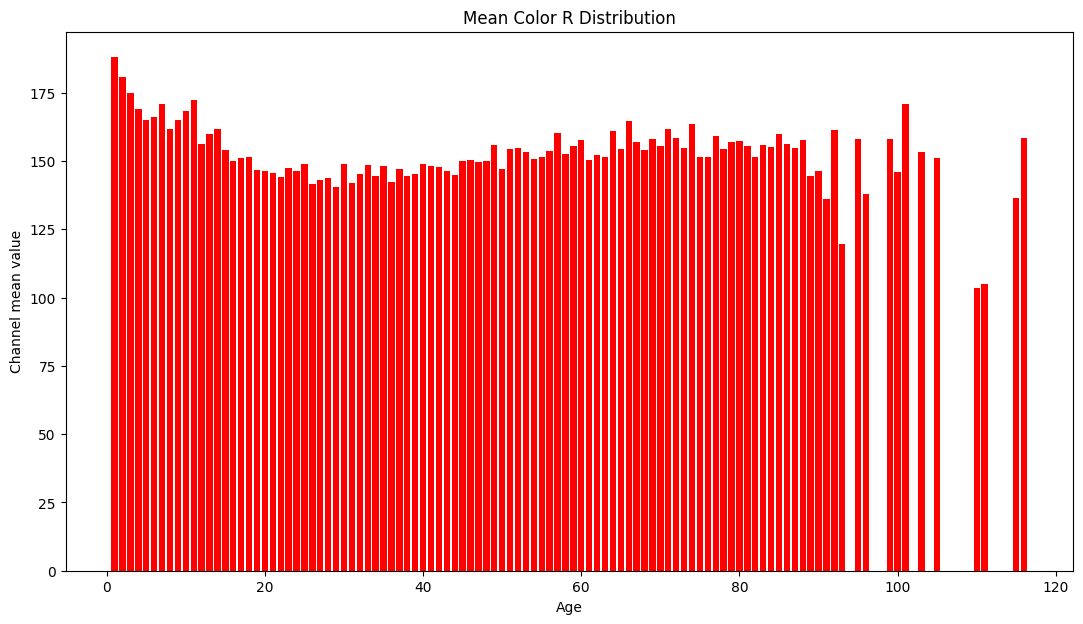

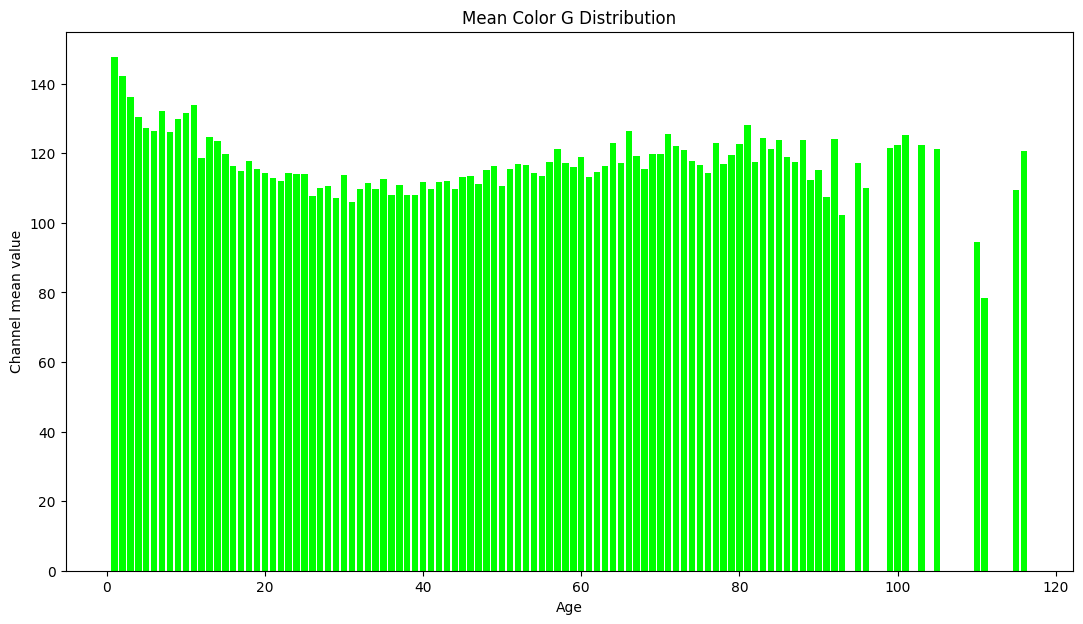

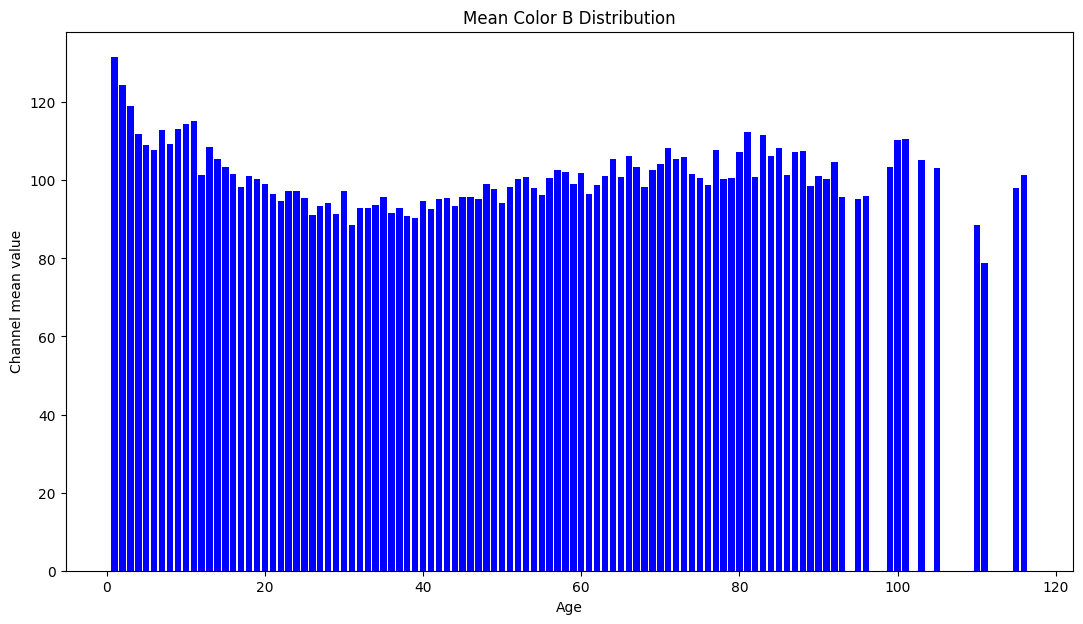

In [106]:
# Plot each
plt.figure(figsize = (13,7))
plt.bar(xAxes,meanGroupedR, color=(1, 0, 0, 1))
plt.title("Mean Color R Distribution")
plt.xlabel("Age")
plt.ylabel("Channel mean value")
plt.show()

plt.figure(figsize = (13,7))
plt.bar(xAxes,meanGroupedG, color=(0, 1, 0, 1))
plt.title("Mean Color G Distribution")
plt.xlabel("Age")
plt.ylabel("Channel mean value")
plt.show()

plt.figure(figsize = (13,7))
plt.bar(xAxes,meanGroupedB, color=(0, 0, 1, 1))
plt.title("Mean Color B Distribution")
plt.xlabel("Age")
plt.ylabel("Channel mean value")
plt.show()

#### Grayscale Example
The histogram detects a large number of light pixels (>200) which most likely correspond to the face, and a number of dark pixels (<50) corresponding to the background.

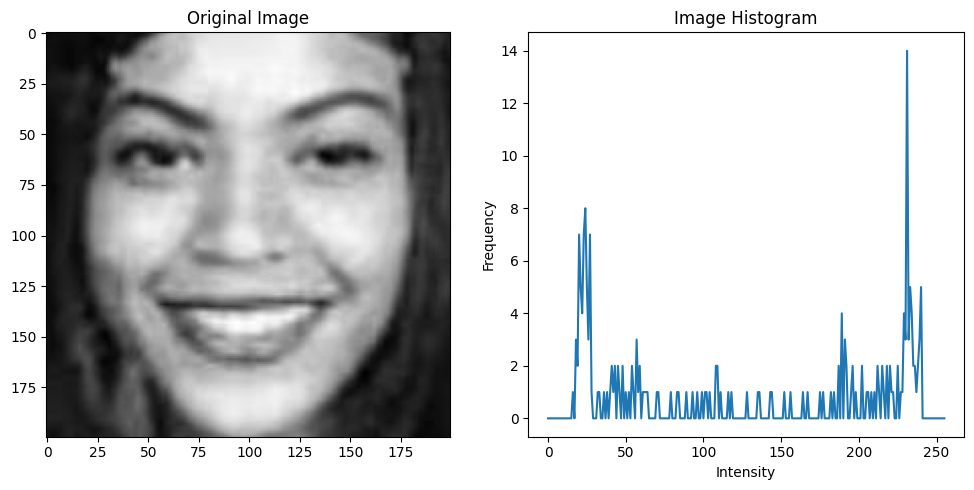

In [25]:
# Load as grayscale image
image = cv2.imread(files[1000], 0) 

# Calculate the histogram
histogram = cv2.calcHist(image, [0], None, [256], [0, 256])

# Plot the histogram
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.plot(histogram)
plt.xlabel('Intensity')
plt.ylabel('Frequency')
plt.title('Image Histogram')
plt.tight_layout()
plt.show() 

#### Similarity

SSIM score, ranges from -1 to 1. The higher the value the more similar the images.

In [113]:
ssim = []

for x in range(len(files)-1):
    try:
        image1 = cv2.imread(files[x])
        image2 = cv2.imread(files[len(files)-1-x])
        image2 = cv2.resize(image2, (image1.shape[1], image1.shape[0]), interpolation = cv2.INTER_AREA)
        # Convert images to grayscale
        image1_gray = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
        image2_gray = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
        # Calculate SSIM
        ssim_score = metrics.structural_similarity(image1_gray, image2_gray, full=True)
        ssim.append(round(ssim_score[0], 2))
    except Exception as e:
        print("Couldn't parse the file: " + filename)


In [114]:
# Average SSIM similarity
sum(ssim)/len(ssim)

0.33523684987556973

#### Feature extraction based on Histogram of Oriented Gradients

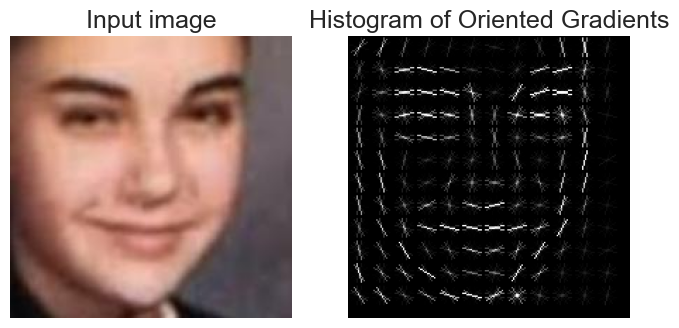

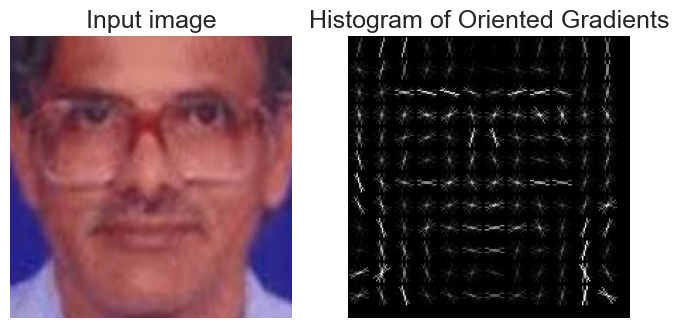

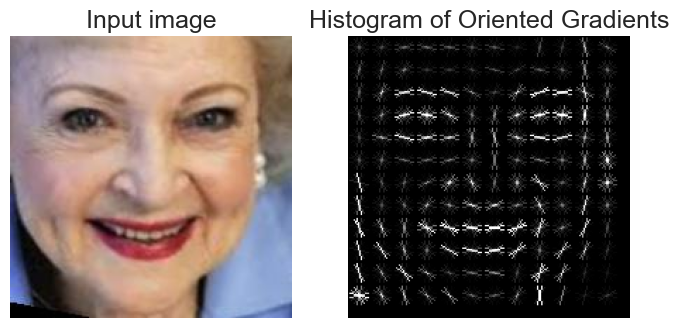

0.3173776781426644

In [7]:
image = imread(files[999])

fd, hog_image = hog(
    image,
    orientations=8,
    pixels_per_cell=(16, 16),
    cells_per_block=(1, 1),
    visualize=True,
    channel_axis=-1,
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()


image = imread(files[20000])

fd, hog_image = hog(
    image,
    orientations=8,
    pixels_per_cell=(16, 16),
    cells_per_block=(1, 1),
    visualize=True,
    channel_axis=-1,
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()



image = imread(files[23001])

fd, hog_image = hog(
    image,
    orientations=8,
    pixels_per_cell=(16, 16),
    cells_per_block=(1, 1),
    visualize=True,
    channel_axis=-1,
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()
np.mean(fd)

##### HOG mean and standard deviation

In [32]:
hogMeans = [ [] for _ in range(int(MAXAGE) + 1) ]
hogStandardDeviations = [ [] for _ in range(int(MAXAGE) + 1) ]

for filePath in files:
    try:
        path, filename = os.path.split(filePath)
        filename, ext = os.path.splitext(filename)
        age, _, _, _ = filename.split("_")
        image = imread(filePath)
        fd, hog_image = hog(
        image,
        orientations=8,
        pixels_per_cell=(16, 16),
        cells_per_block=(1, 1),
        visualize=True,
        channel_axis=-1,
        )
        hogMeans[int(age)].append(np.mean(fd))
        hogStandardDeviations[int(age)].append(np.std(fd))
    except Exception as e:
        print("Couldn't parse the file: " + filename)

Couldn't parse the file: 39_1_20170116174525125.jpg.chip
Couldn't parse the file: 61_1_20170109142408075.jpg.chip
Couldn't parse the file: 61_1_20170109150557335.jpg.chip


<Axes: xlabel='HOG standard deviation', ylabel='age'>

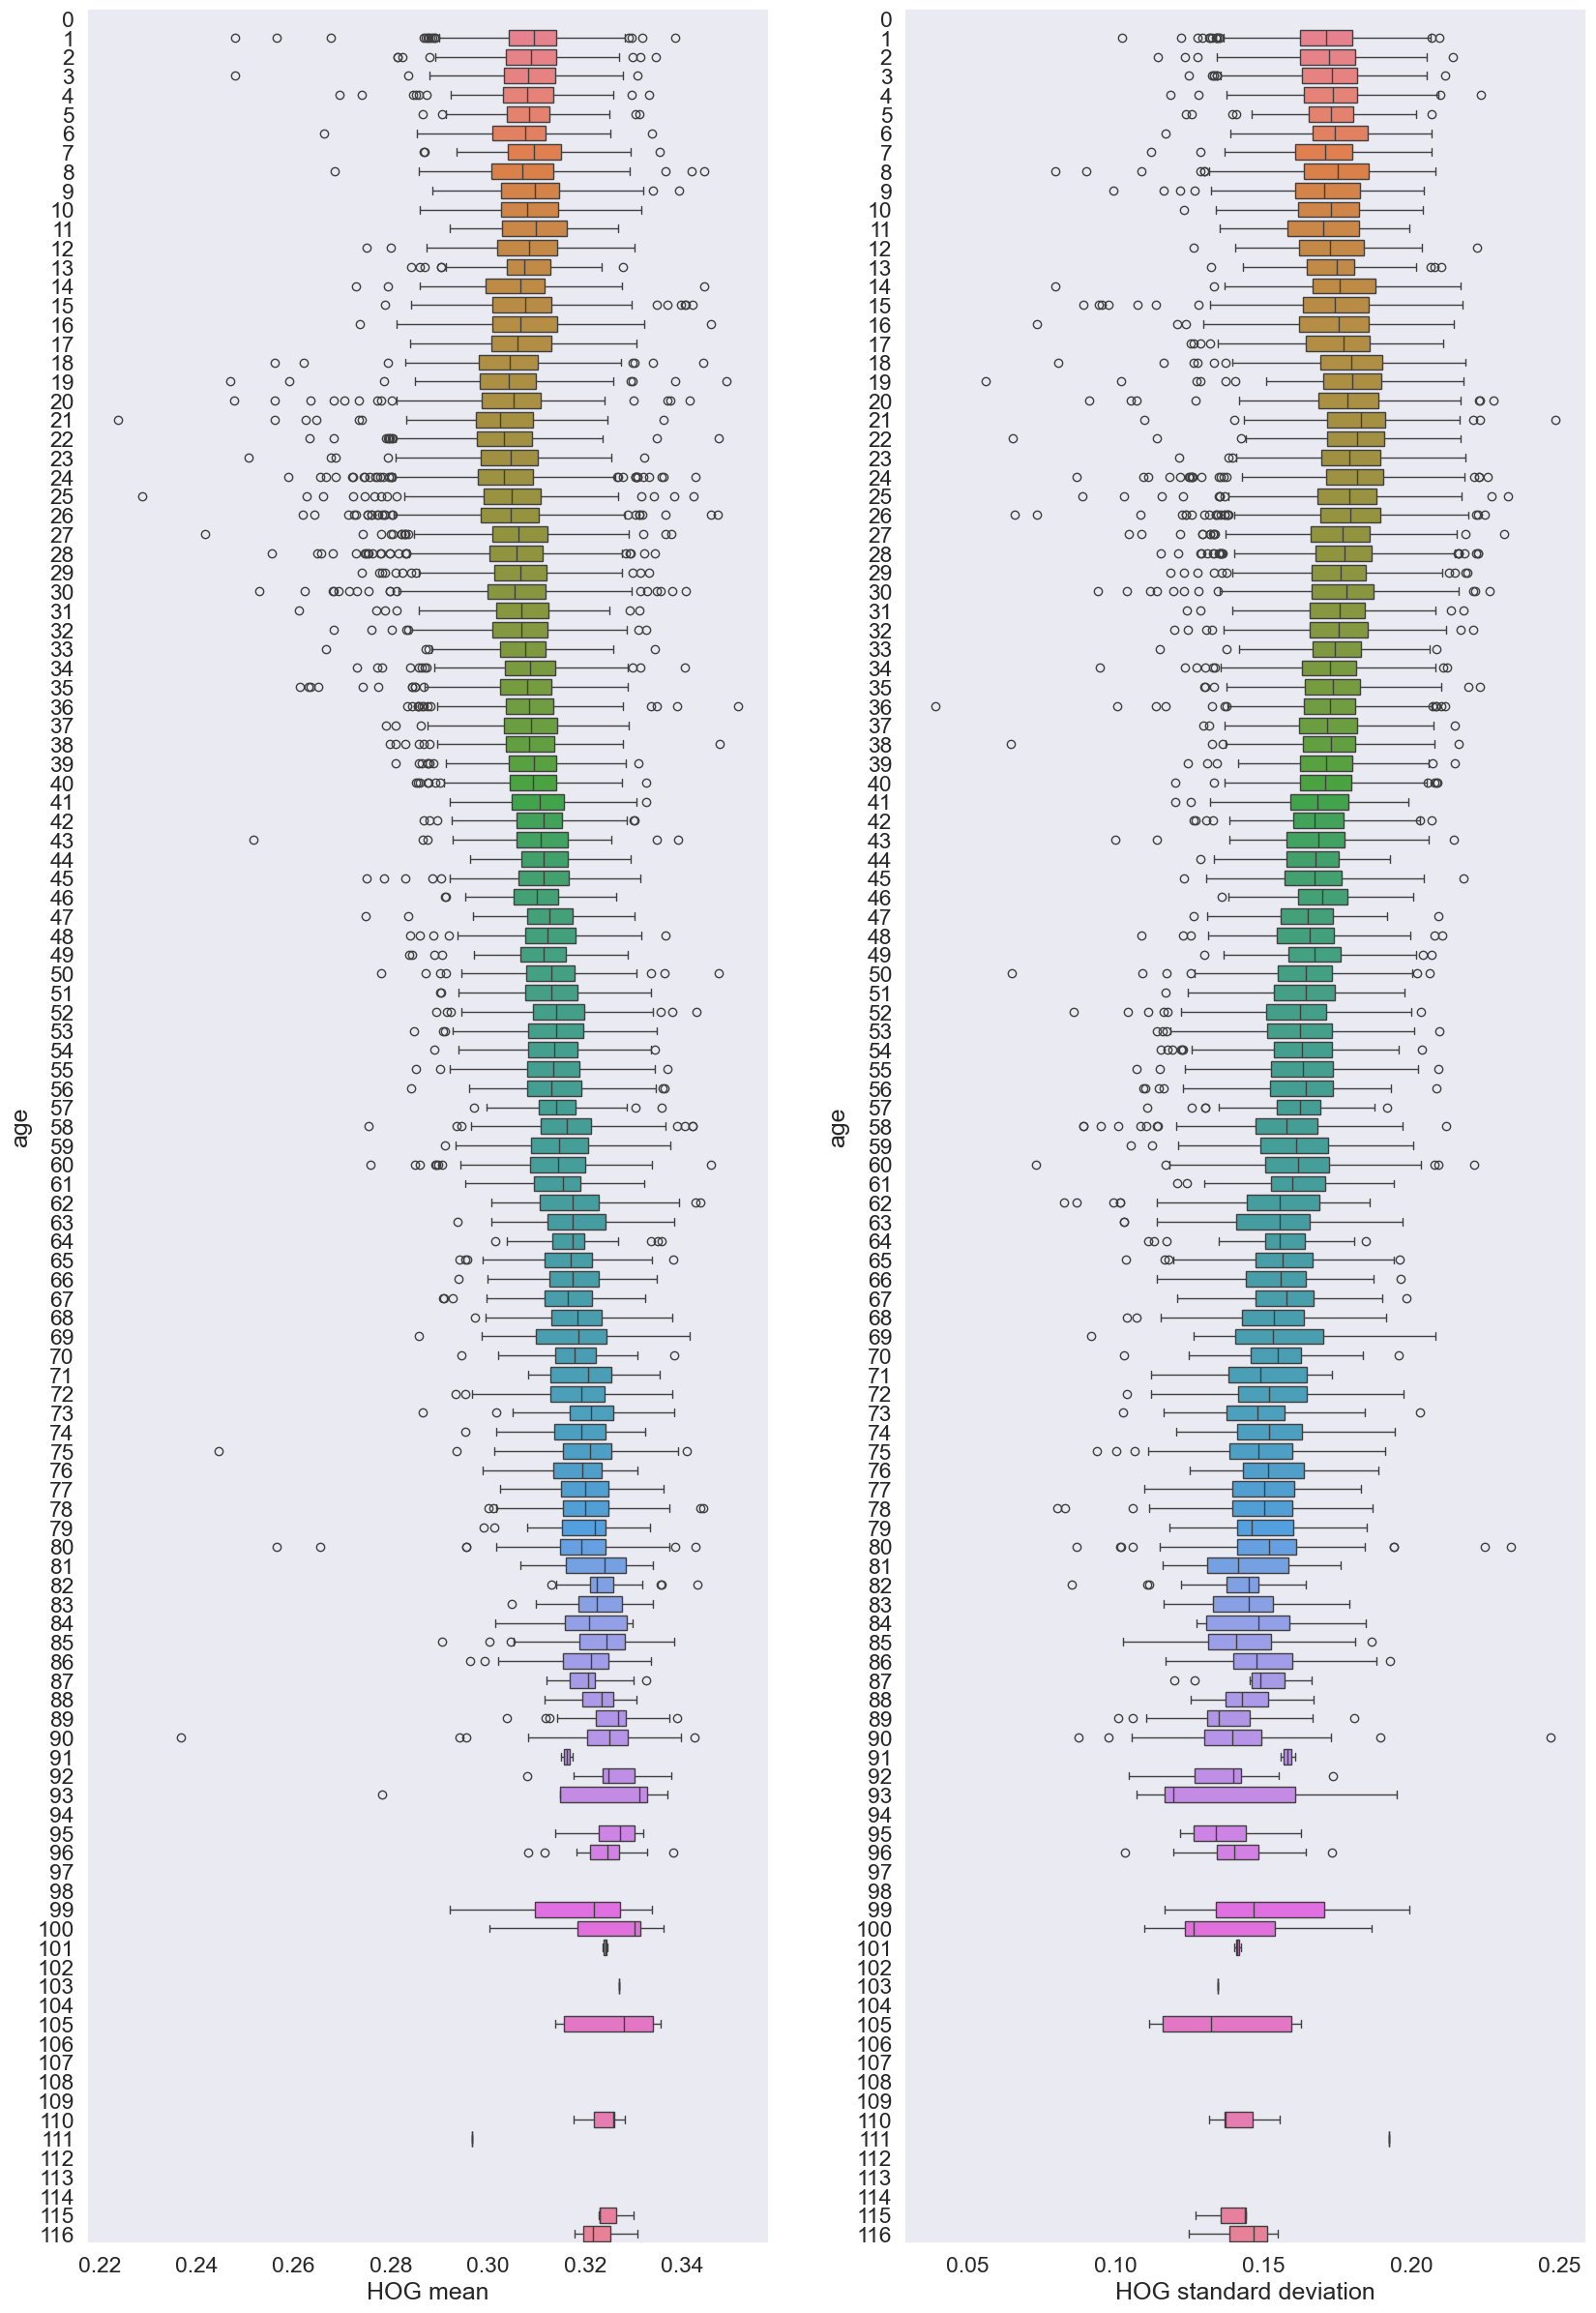

In [27]:
f, axes = plt.subplots(figsize=(20, 30), ncols=2, nrows=1)
axes[0].set_xlabel('HOG mean')
axes[0].set_ylabel('age')
axes[1].set_xlabel('HOG standard deviation')
axes[1].set_ylabel('age')
sns.boxplot( data=hogMeans, orient="h", ax=axes[0])
sns.boxplot( data=hogStandardDeviations, orient="h", ax=axes[1])

#### Examples

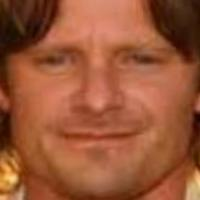

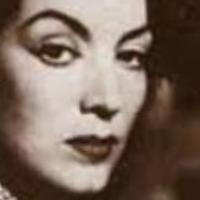

In [25]:
for i in range(2):
    img = Image.open(df['file'][random.randint(1,len(df['file'])-1)])
    display(img)

### Face Recognition Dataset
- Collected by cropping frames from 6 different stock videos
- All images contain at most one face
- Labels with bounding boxes created by hand via labelme
- Data has been augumented by randomly cropping, flipping, changing brightness etc.

In [52]:
trainFiles = glob.glob(os.path.join(RECOGNITION_TRAIN_DIR, "*.jpg"))
testFiles = glob.glob(os.path.join(RECOGNITION_TEST_DIR, "*.jpg"))
valFiles = glob.glob(os.path.join(RECOGNITION_VAL_DIR, "*.jpg"))

In [53]:
print("Train: " + str(len(trainFiles)))
print("Test: " + str(len(testFiles)))
print("Validation: " + str(len(valFiles)))

Train: 2520
Test: 540
Validation: 540


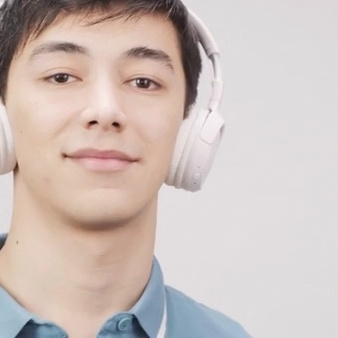

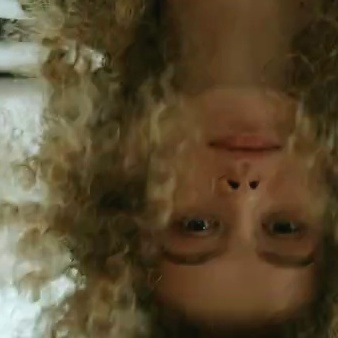

In [92]:
for i in range(2):
    img = Image.open(trainFiles[random.randint(1,len(trainFiles))])
    display(img)